<h2><center> Capstone Project 1: Statistical Model</center></h2>

In this section, we do a statistical modelling of the data to predict whether a driver gets warning or citation for the particular violation. 

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn import metrics
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import classification_report, roc_curve, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier

In [2]:
# Read the accident data from csv
df_traffic = pd.read_csv('data_wrangled_long.csv', 
                         index_col = 'Date Of Stop_Time Of Stop',
                         parse_dates = True,
                         infer_datetime_format = True)

df_traffic['V_sage'] = (df_traffic.V_Age - df_traffic.V_Age.min())/\
                  (df_traffic.V_Age.max() - df_traffic.V_Age.min())

not_relevant = ['Latitude', 'Longitude', 'Year', 'Description', 
                'Make', 'Model', 'Color', 'datetime', 'V_Age']
df_traffic.drop(labels = not_relevant, axis = 1,  inplace = True)

In [3]:
# Get X and y from data 
y = df_traffic['Violation Type_Warning']
df_X1 = df_traffic.drop('Violation Type_Warning', axis = 1)
X = df_X1.values

# now,  do a Logistic regression to the data. 
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                   test_size = 0.5, random_state=42)

At the first step, we begin if we can make a prediction using simple logistic regression. We first optimize the regression using randomized search. The best parameters obtained from randomized search will be used to make the prediction. 

In [5]:
# Setup the hyperparameter grid for a randomized grid search
param_grid = {'C': np.logspace(-5,5,50), 'fit_intercept': [True, False],
             'intercept_scaling': np.arange(0.05, 10, 0.25), 
             'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'] ,
             'random_state': [77]}

# Instantiate a logistic regression classifier: Random Forest
logreg = LogisticRegression()

# Instantiate the GridSearchCV object: logreg_cv
model_lr = RandomizedSearchCV(logreg, param_grid, 
                              cv = 5, 
                              n_jobs = -1)

# Fit it to the data
model_lr.fit(X, y)

# Print the tuned parameters and score
print("Tuned Logistic Regression Parameters: {}".format(model_lr.best_params_)) 
print("Best score is {}".format(model_lr.best_score_))


Tuned Logistic Regression Parameters: {'solver': 'newton-cg', 'random_state': 77, 'intercept_scaling': 0.55, 'fit_intercept': True, 'C': 0.30888435964774846}
Best score is 0.7613114568637368


[[197704  88960]
 [ 52774 261634]]
             precision    recall  f1-score   support

    Citaton       0.79      0.69      0.74    286664
    Warning       0.75      0.83      0.79    314408

avg / total       0.77      0.76      0.76    601072



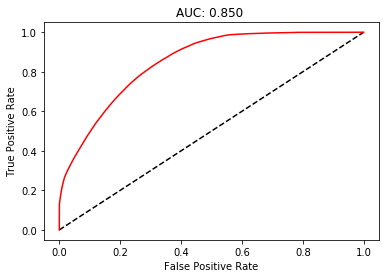

In [4]:
logreg = LogisticRegression(solver = 'newton-cg', n_jobs = -1, intercept_scaling = 0.55,
                            fit_intercept = True, C = 0.3089,
                            multi_class = 'ovr', class_weight =  'balanced',
                            random_state = 77)

# Fit the classifier to the training data
logreg.fit(X_train, y_train)

logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred,  target_names = ['Citaton', 'Warning']))

y_pred_prob = logreg.predict_proba(X_test)[:,1]

fpr_lr,tpr_lr, thresholds_lr = roc_curve(y_test, y_pred_prob)

plt.plot([0, 1], [0, 1], 'k--', fpr_lr, tpr_lr, 'r')

# Plot ROC curve
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("AUC: %5.3f "%( roc_auc_score(y_test, y_pred_prob)))

#plt.title('ROC Curve')
plt.show()

C:\Users\lekhn_000\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


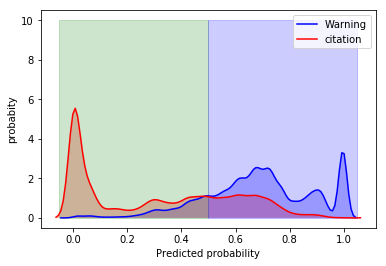

In [5]:
y_pred_prob = logreg.predict_proba(X)[:,1]
ypp = pd.DataFrame(data = y_pred_prob, columns = ['predicted'])
ypp['real'] = y.values

ypp1 = ypp[ypp.real == 1]
ypp0 = ypp[ypp.real == 0]
ax = sns.kdeplot(ypp1.predicted, shade=True, color="b", label = 'Warning')
sns.kdeplot(ypp0.predicted, shade=True, color="r", ax = ax, label = 'citation')

plt.fill_between([-0.05,0.5], 0, 10, color = 'g', alpha = 0.2)
plt.fill_between([0.5,1.05], 0, 10, color = 'b', alpha = 0.2)

plt.xlabel('Predicted probability')
plt.ylabel('probabity')
plt.show()

In [14]:
# Setup the hyperparameter grid for a 
param_grid = {'max_depth': [39], 
             'min_samples_leaf': np.arange(1,500,2), 
             'min_weight_fraction_leaf': [0], 
             'random_state' : [77], 'class_weight': ['balanced']}

# Instantiate a 
model_tree = DecisionTreeClassifier()

# Instantiate the GridSearchCV object: logreg_cv
model_cv = RandomizedSearchCV(model_tree, param_grid, 
                              cv = 5, 
                              n_jobs = -1)

# Fit it to the data
model_cv.fit(X, y)

# Print the tuned parameters and score
print("Tuned Decision Tree Parameters: {}".format(model_cv.best_params_)) 
print("Best score is {}".format(model_cv.best_score_))

Tuned Decision Tree Parameters: {'random_state': 77, 'min_weight_fraction_leaf': 0, 'min_samples_leaf': 73, 'max_depth': 39, 'class_weight': 'balanced'}
Best score is 0.7737259429818724


[[195614  91050]
 [ 42809 271599]]
             precision    recall  f1-score   support

    Citaton       0.82      0.68      0.75    286664
    Warning       0.75      0.86      0.80    314408

avg / total       0.78      0.78      0.78    601072

AUC: 0.8614239224491629


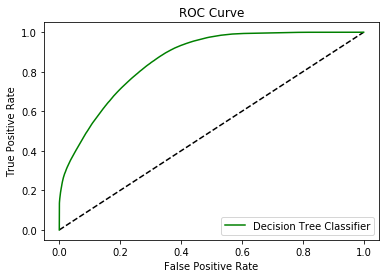

In [30]:
model_tree = DecisionTreeClassifier(max_depth = 39, 
                                    min_weight_fraction_leaf = 0,
                                    min_samples_leaf = 127,
                                    class_weight = 'balanced',
                                    random_state = 77)

model_tree.fit(X_train, y_train)

y_pred = model_tree.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred,  target_names = ['Citaton', 'Warning']))

y_pred_prob = model_tree.predict_proba(X_test)[:,1]

fpr_dt,tpr_dt, thresholds = roc_curve(y_test, y_pred_prob)

print("AUC: {}".format(roc_auc_score(y_test, y_pred_prob)))

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_dt, tpr_dt, 'g',label = 'Decision Tree Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


In [16]:
# Setup the hyperparameter grid for a random forest gridsearch 
param_grid = {'max_features': np.arange(0,0.5, 0.05), 'n_estimators': np.arange(5,200,1), 
             'min_samples_leaf': np.arange(2, 100, 1), 
             'criterion': ['gini', 'entropy'], 'max_depth': np.arange(2, 100, 1), 
             'min_weight_fraction_leaf': np.arange(0,0.5, 0.05),
             'oob_score': [True, False], 'class_weight': ['balanced', 'balanced_subsample'], 
             'random_state':[77]}

# Instantiate a logistic regression classifier: Random Forest
model_rf = RandomForestClassifier()

# Instantiate the GridSearchCV object: logreg_cv
model_cv = RandomizedSearchCV(model_rf, param_grid, 
                              cv = 5, 
                              n_jobs = -1)

# Fit it to the data
model_cv.fit(X, y)

# Print the tuned parameters and score
print("Tuned Random Forest Parameters: {}".format(model_cv.best_params_)) 
print("Best score is {}".format(model_cv.best_score_))


G:\Anaconda\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
G:\Anaconda\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


Tuned Random Forest Parameters: {'random_state': 77, 'oob_score': True, 'n_estimators': 5, 'min_weight_fraction_leaf': 0.0, 'min_samples_leaf': 37, 'max_features': 0.2, 'max_depth': 49, 'criterion': 'gini', 'class_weight': 'balanced_subsample'}
Best score is 0.7760709199563447


AUC: 0.865582808485542


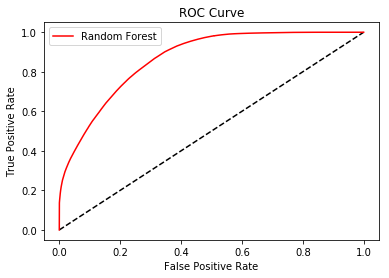

In [8]:
# Now it is turn of random forest
model_rf = RandomForestClassifier(n_estimators = 149, min_weight_fraction_leaf = 0.0, min_samples_leaf = 10,
                                  max_features = 0.2, max_depth = 45, criterion = 'gini', class_weight = 'balanced_subsample',
                                  oob_score = True,  n_jobs = -1, random_state = 77)
# Train the model using the training sets and check score
model_rf.fit(X_train, y_train)
#Predict Output
y_pred = model_rf.predict(X_test)

print(classification_report(y_test, y_pred,  target_names = ['Citaton', 'Warning']))


# Compute predicted probabilities: y_pred_prob
y_pred_prob = model_rf.predict_proba(X_test)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr,tpr, thresholds = roc_curve(y_test, y_pred_prob)

print("AUC: {}".format(roc_auc_score(y_test, y_pred_prob)))

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, 'r',label = 'Random Forest')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


C:\Users\lekhn_000\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


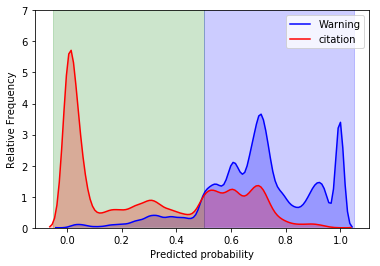

In [9]:
y_pred_prob = model_rf.predict_proba(X)[:,1]
ypp = pd.DataFrame(data = y_pred_prob, columns = ['predicted'])
ypp['real'] = y.values

ypp1 = ypp[ypp.real == 1]
ypp0 = ypp[ypp.real == 0]
ax = sns.kdeplot(ypp1.predicted, shade=True, color="b", label = 'Warning')
plt.fill_between([-0.05,0.5], 0, 10, color = 'g', alpha = 0.2)
plt.fill_between([0.5,1.05], 0, 10, color = 'b', alpha = 0.2)
plt.ylim(0, 7)
sns.kdeplot(ypp0.predicted, shade=True, color="r", ax = ax, label = 'citation')
plt.xlabel('Predicted probability')
plt.ylabel('Relative Frequency')
plt.show()

In [22]:
param_grid = {'alpha': np.logspace(-9, 0, 10)}

mlp = MLPClassifier()

model_cv = RandomizedSearchCV(mlp, param_grid, 
                              cv = 5, 
                              n_jobs = -1)

model_cv.fit(X, y)

# Print the tuned parameters and score
print("Tuned Multi layer Processing Parameters: {}".format(model_cv.best_params_)) 
print("Best score is {}".format(model_cv.best_score_))

Tuned Multi layer Processing Parameters: {'alpha': 1e-08}
Best score is 0.7794216000745335


AUC: 0.8656780659128546
[[190949  95715]
 [ 34861 279547]]
             precision    recall  f1-score   support

    Citaton       0.85      0.67      0.75    286664
    Warning       0.74      0.89      0.81    314408

avg / total       0.79      0.78      0.78    601072



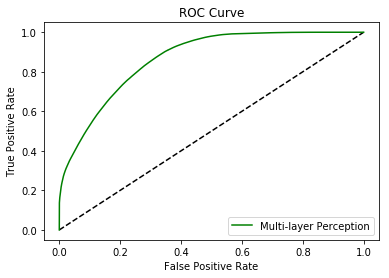

In [11]:
from sklearn.neural_network import MLPClassifier

model_mlp = MLPClassifier(alpha = 1e-8)

model_mlp.fit(X_train, y_train)
#Predict Output
y_pred = model_mlp.predict(X_test)

# Compute predicted probabilities: y_pred_prob
y_pred_prob = model_mlp.predict_proba(X_test)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr_mlp,tpr_mlp, thresholds = roc_curve(y_test, y_pred_prob)

print("AUC: {}".format(roc_auc_score(y_test, y_pred_prob)))

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_mlp, tpr_mlp, 'g',label = 'Multi-layer Perception')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred,  target_names = ['Citaton', 'Warning']))

plt.show()

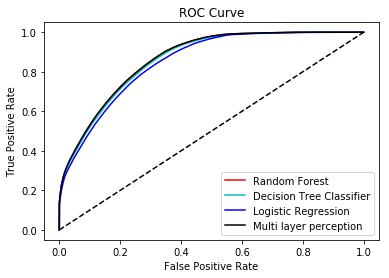

In [44]:
plt.plot([0, 1], [0, 1], 'k--')

y_pred_prob = model_rf.predict_proba(X_test)[:,1]
fpr,tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.plot(fpr, tpr, 'r', label = 'Random Forest')

y_pred_prob = model_tree.predict_proba(X_test)[:,1]
fpr,tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.plot(fpr, tpr, 'c', label = 'Decision Tree Classifier')

y_pred_prob = logreg.predict_proba(X_test)[:,1]
fpr,tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.plot(fpr, tpr, 'b', label = 'Logistic Regression')

y_pred_prob = model_mlp.predict_proba(X_test)[:,1]
fpr,tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.plot(fpr, tpr, 'k', label = 'Multi layer perception')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')

plt.legend()
plt.show()

C:\Users\lekhn_000\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


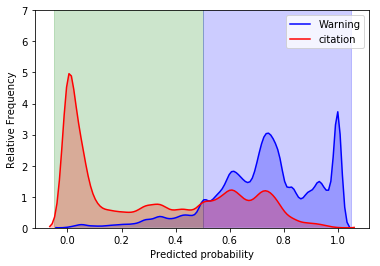

In [18]:
y_pred_prob = model_mlp.predict_proba(X)[:,1]
ypp = pd.DataFrame(data = y_pred_prob, columns = ['predicted'])
ypp['real'] = y.values

ypp1 = ypp[ypp.real == 1]
ypp0 = ypp[ypp.real == 0]
ax = sns.kdeplot(ypp1.predicted, shade=True, color="b", label = 'Warning')
plt.fill_between([-0.05,0.5], 0, 10, color = 'g', alpha = 0.2)
plt.fill_between([0.5,1.05], 0, 10, color = 'b', alpha = 0.2)
plt.ylim(0, 7)
sns.kdeplot(ypp0.predicted, shade=True, color="r", ax = ax, label = 'citation')
plt.xlabel('Predicted probability')
plt.ylabel('Relative Frequency')
plt.show()

In [36]:
y_pred_prob = logreg.predict_proba(X_test)[:,1]
print('Logistic regression ROC:', roc_auc_score(y_test, y_pred_prob))
y_pred_prob = model_tree.predict_proba(X_test)[:,1]
print('Decision Tree ROC:', roc_auc_score(y_test, y_pred_prob))
y_pred_prob = model_rf.predict_proba(X_test)[:,1]
print('Random Forest ROC:', roc_auc_score(y_test, y_pred_prob))
y_pred_prob = model_mlp.predict_proba(X_test)[:,1]
print('Multi Layer perception ROC:', roc_auc_score(y_test, y_pred_prob))

Logistic regression ROC: 0.850387103392937
Decision Tree ROC: 0.8614239224491629
Random Forest ROC: 0.865582808485542
Multi Layer perception ROC: 0.8656780659128546


C:\Users\lekhn_000\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


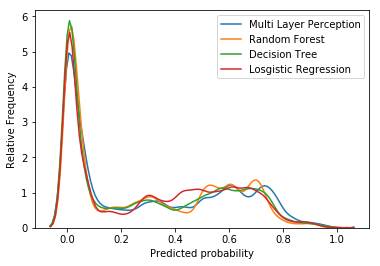

In [43]:
y_pred_prob = model_mlp.predict_proba(X)[:,1]
ypp = pd.DataFrame(data = y_pred_prob, columns = ['predicted'])
ypp['real'] = y.values

ypp0 = ypp[ypp.real == 0]
ax = sns.kdeplot(ypp0.predicted, shade=False, label = 'Multi Layer Perception')

y_pred_prob = model_rf.predict_proba(X)[:,1]
ypp = pd.DataFrame(data = y_pred_prob, columns = ['predicted'])
ypp['real'] = y.values

ypp0 = ypp[ypp.real == 0]
sns.kdeplot(ypp0.predicted, shade=False, label = 'Random Forest', ax = ax)

y_pred_prob = model_tree.predict_proba(X)[:,1]
ypp = pd.DataFrame(data = y_pred_prob, columns = ['predicted'])
ypp['real'] = y.values

ypp0 = ypp[ypp.real == 0]
sns.kdeplot(ypp0.predicted, shade=False, label = 'Decision Tree', ax = ax)

y_pred_prob = logreg.predict_proba(X)[:,1]
ypp = pd.DataFrame(data = y_pred_prob, columns = ['predicted'])
ypp['real'] = y.values

ypp0 = ypp[ypp.real == 0]
sns.kdeplot(ypp0.predicted, shade=False, label = 'Losgistic Regression', ax = ax)



plt.xlabel('Predicted probability')
plt.ylabel('Relative Frequency')
plt.show()